In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')
sys.path.append('../video-classification/ResNetCRNN/')

from helpers_lstm import *
from helpers_training import *

In [3]:
tensor_transform = get_tensor_transform('ImageNet', True)
train_spat_transform = get_spatial_transform(2)
train_temp_transform = get_temporal_transform()
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/nsea_video_jpegs/'
df = pd.read_csv('./small_dataset_csvs/events_with_number_of_frames_stratified.csv')
df_train = get_df(df, 20, True, False, False)
class_image_paths, end_idx = get_indices(df_train, root_dir)
train_loader = get_loader(16, 4, end_idx, class_image_paths, train_temp_transform, train_spat_transform, tensor_transform, True, False)
df_valid = get_df(df, 20, False, True, False)
class_image_paths, end_idx = get_indices(df_valid, root_dir)
valid_loader = get_loader(16, 4, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, True, False)
df_test = get_df(df, 20, False, False, True)
class_image_paths, end_idx = get_indices(df_test, root_dir)
test_loader = get_loader(16, 4, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, True, False)


In [4]:
device = torch.device('cuda')
cnn_encoder = ResCNNEncoder().to(device)
adaptive_pool = AdaptiveConcatPool2d()
cnn_encoder.resnet[8] = adaptive_pool
for param in cnn_encoder.parameters():
    param.requires_grad = False
for param in cnn_encoder.resnet[8].parameters():
    param.requires_grad = True
for param in cnn_encoder.headbn1.parameters():
    param.requires_grad = True
for param in cnn_encoder.fc1.parameters():
    param.requires_grad = True
    
rnn_decoder = DecoderRNNattention(batch_size=4).to(device)
for param in rnn_decoder.parameters():
    param.requires_grad = True

In [5]:
crnn_params, cnn_encoder, rnn_decoder = parallelize_model(cnn_encoder, rnn_decoder)

model = nn.Sequential(cnn_encoder,rnn_decoder)
torch.cuda.empty_cache()

Using 4 GPUs!


In [6]:
checkpoint = torch.load('/media/scratch/astamoulakatos/saved-lstm-models/best-checkpoint-006epoch.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print('loading pretrained freezed model!')

loading pretrained freezed model!


In [7]:
from predictions import *

In [8]:
model = model.eval()

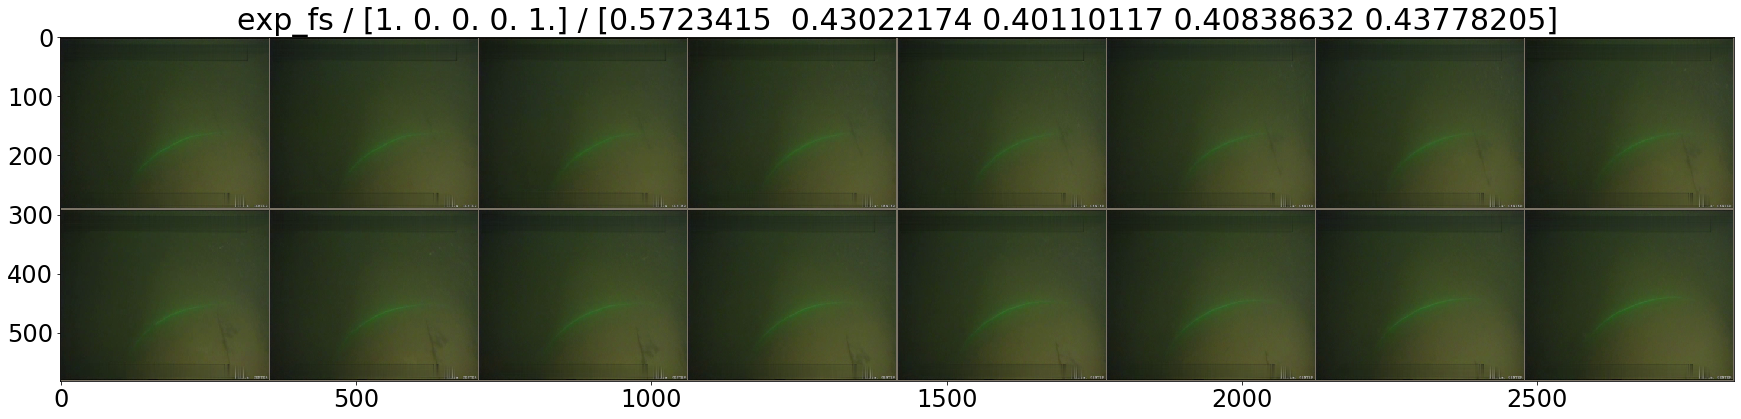

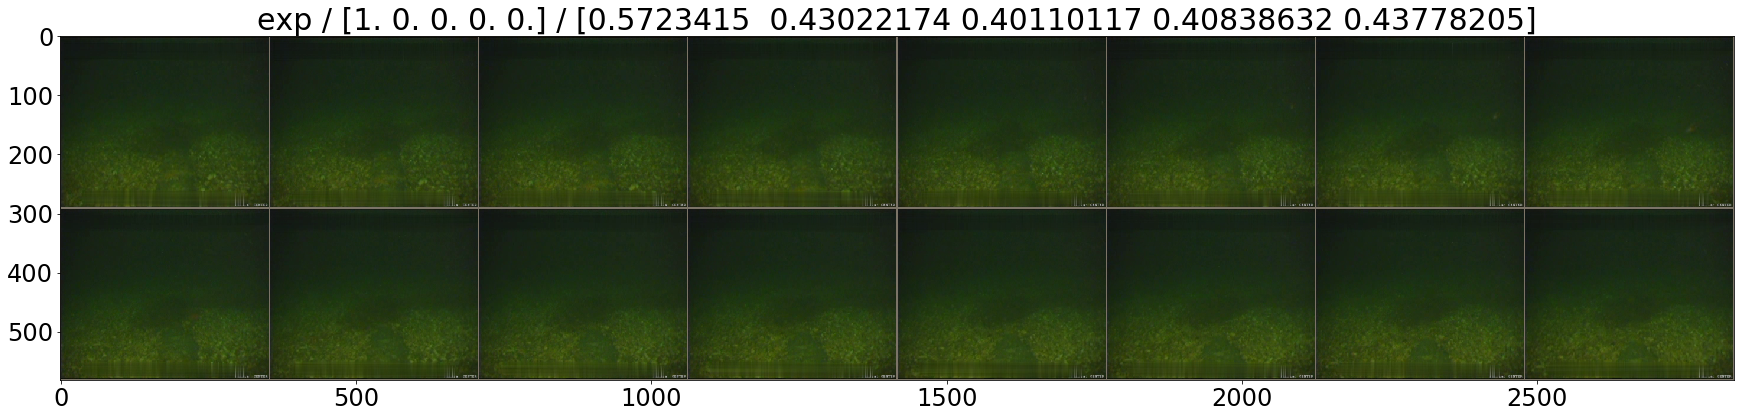

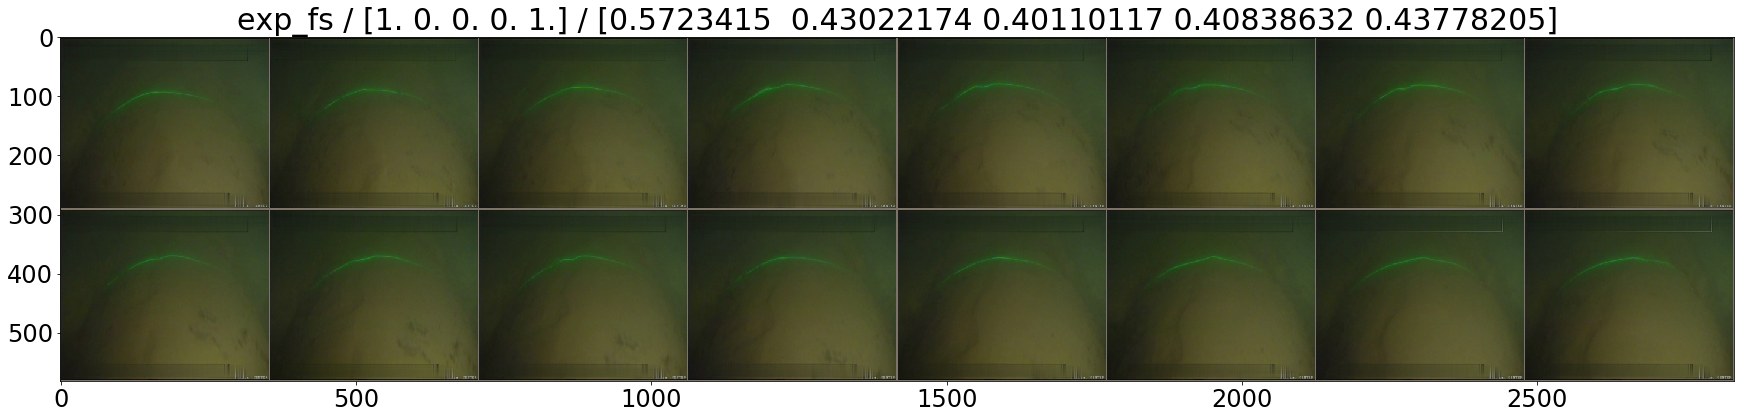

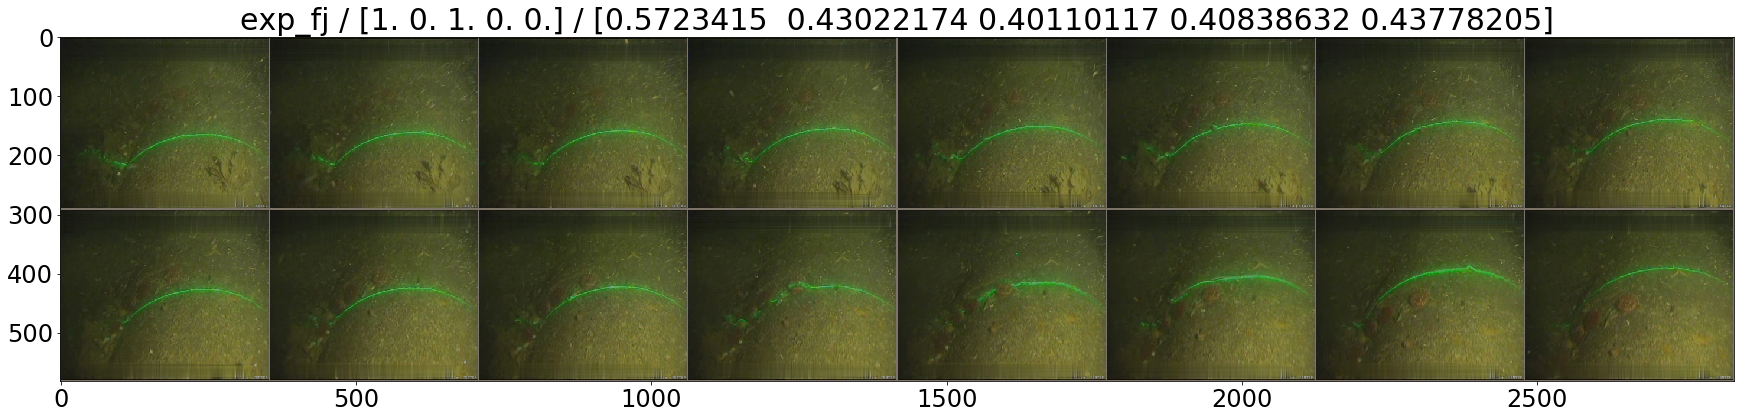

In [9]:
plot_predictions_actuals(valid_loader, 4, model, device, False)

# Threshold search

In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in valid_loader:
        X = X.to(device)
        y = Variable(y.float()).to(device) 
        y = y.squeeze(dim=1)
        y = y.float()
        output = model(X)
        y = y.detach().cpu()
        #loss = criterion(output, y)
        preds = torch.sigmoid(output)
        preds = preds.to(torch.float32) 
        preds = preds.detach().cpu()
        y_pred.append(preds)
        y_true.append(y)

In [ ]:
y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [ ]:
y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [ ]:
from helpers_thresholds import *

In [ ]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

In [ ]:
thresholds = nsea_compute_thresholds(y_tr, y_pr, classes)

In [ ]:
thresholds

## validation set

In [ ]:
new_compute_metrics(y_tr, y_pr, thresholds, classes)

# test set

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = Variable(y.float()).to(device) 
        y = y.squeeze(dim=1)
        y = y.float()
        output = model(X)
        y = y.detach().cpu()
        #loss = criterion(output, y)
        preds = torch.sigmoid(output)
        preds = preds.to(torch.float32) 
        preds = preds.detach().cpu()
        y_pred.append(preds)
        y_true.append(y)

In [ ]:
y_tr = np.vstack([t.__array__() for tensor in y_true for t in tensor])

In [ ]:
y_pr = np.vstack([t.__array__() for tensor in y_pred for t in tensor])

In [ ]:
new_compute_metrics(y_tr, y_pr, thresholds, classes)